In [1]:
import random
import calendar
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from deap import base, tools, creator, algorithms

In [2]:
data = pd.read_csv('employee_shift.csv')
data.sample(20)

,Employee_Name,Day_of_the_Month,Day_of_the_Week,Gender,Religion,Shift_ID
193,Antika,8,Selasa,Perempuan,Kristen,7
39,Dinda,9,Rabu,Perempuan,Islam,7
175,Retno,21,Senin,Perempuan,Islam,1
311,Rini,2,Rabu,Perempuan,Islam,3
332,Rini,23,Rabu,Perempuan,Islam,3
181,Retno,27,Minggu,Perempuan,Islam,4
276,Dzaki,29,Selasa,Laki-laki,Islam,5
248,Dzaki,1,Selasa,Laki-laki,Islam,3
312,Rini,3,Kamis,Perempuan,Islam,6
309,Mugny,31,Kamis,Laki-laki,Islam,2


In [3]:
# Define shift schedule (shift ID)
SHIFTS = {
    1: ("10:00 AM", "18:00 PM"),
    2: ("14:00 PM", "22:00 PM"),
    3: ("12:00 PM", "20:00 PM"),
    4: ("10:00 AM", "20:00 PM"),
    5: ("10:00 AM", "19:00 PM"),
    6: ("10:00 AM", "22:00 PM"), # Full Shift
    7: ("OFF", "OFF DAY") # Off Day
}

# Setup DEAP genetic algorithm
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [4]:
def init_individual():
    # Create a schedule for each employee, instead of a single shift
    num_employees = len(data)
    # Create a list of schedules for each employee. Each schedule is a list of 7 shifts
    return [[random.choice(list(SHIFTS.keys())) for _ in range(7)]
            for _ in range(num_employees)]

def custom_mutation(individual, indpb):
    """Custom mutation to handle integer shift IDs."""
    # Iterate through each employee's schedule
    for employee_schedule in individual:
        # Iterate through each day in the schedule
        for i in range(len(employee_schedule)):
            if random.random() < indpb:
                # Instead of flipping the bit, select a new random shift ID
                employee_schedule[i] = random.choice(list(SHIFTS.keys()))
    return individual,  # Return the modified individual as a tuple

In [5]:
# Aturan 1: Tidak boleh mengambil cuti pada akhir pekan
def rule_weekend_no_off(schedule):
    weekday_off_count = 0
    for i in range(0, 5):  # Check for Monday-Friday
        if schedule[i] == 7:
            weekday_off_count += 1
    if weekday_off_count > 1:
        return False
    return True

# Aturan 2: Shift sebelum dan setelah libur
def rule_shift_before_after_off(schedule):
    for i in range(1, len(schedule)-1):
        if schedule[i] == 7:  # Check for "OFF" day
            if schedule[i-1] not in [1, 4] or schedule[i+1] != 2:  # Before OFF must be shift 1 or 4, after must be 2
                return False
    return True

# Aturan 3: Laki-laki Muslim tidak boleh mengambil shift 1, 3, 4 pada hari Jumat
def rule_friday_shift(schedule, employee):
    friday_shift = schedule[5]  # Index 5 is Friday
    # Ensure Gender and Religion exist in the dataframe, may need to modify the columns
    # based on their actual names in your file.
    gender_col = 'Gender'  # or 'Jenis Kelamin', 'gender', etc.
    religion_col = 'Religion'  # or 'Agama', 'religion', etc.
    if gender_col in employee and religion_col in employee:
        if employee[gender_col] == 'Male' and employee[religion_col] == 'Islam' and friday_shift in [1, 3, 4]:
            return False
    return True

# Rule 4: Karyawan ditempatkan di shift 4 pada akhir pekan (Jumat hingga Minggu)
def rule_weekend_shift(schedule):
    weekend_shifts = [schedule[5], schedule[6]]  # Jumat dan Sabtu (assuming index 5 and 6 are Friday and Saturday)
    if any(shift != 4 for shift in weekend_shifts):  # Should be shift 4
        return False
    return True

# Rule 5: Minimal dua orang untuk menutup toko di shift malam (shift 6)
def rule_min_two_for_closing(schedules):
    for day in range(len(schedules[0])):  # Loop over each day
        shift_count = sum(1 for schedule in schedules if schedule[day] == 6)
        if shift_count < 2:
            return False
    return True

# Rule 6: Hindari shift pagi setelah shift malam
def rule_no_morning_after_night(schedule):
    for i in range(1, len(schedule)):
        if schedule[i-1] == 6 and schedule[i] == 1:  # If night shift followed by morning shift
            return False
    return True

# Fungsi fitness
def evaluate(individual):
    total_penalty = 0
    for idx, employee_schedule in enumerate(individual):
        employee = data.iloc[idx]  # Get employee data from dataframe
        if not rule_weekend_no_off(employee_schedule):
            total_penalty += 10
        if not rule_friday_shift(employee_schedule, employee):
            total_penalty += 20
        if not rule_shift_before_after_off(employee_schedule):
            total_penalty += 15
        if not rule_weekend_shift(employee_schedule):
            total_penalty += 10
        if not rule_min_two_for_closing(individual):
            total_penalty += 20
        if not rule_no_morning_after_night(employee_schedule):
            total_penalty += 10
    return (total_penalty,)

In [6]:
toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
# Functions for crossover, mutation, selection
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", custom_mutation, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [7]:
# Genetic algorithm parameters
population_size = 150
generations = 200
crossover_prob = 0.7
mutation_prob = 0.3

# Generate initial population
pop = toolbox.population(n=population_size)

# Create stats object
mstats = tools.Statistics(lambda ind: ind.fitness.values)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# Create Hall of Fame object
hof = tools.HallOfFame(1) # Keep only the best individual

# Run the genetic algorithm
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=crossover_prob,
                    mutpb=mutation_prob, ngen=generations,
                    verbose=True, stats=mstats, halloffame=hof)

# Get the best individual
best_individual = tools.selBest(pop, k=1)[0]
print("Best Schedule found:", best_individual)

# Map shift IDs to actual shifts
final_schedule = []

# Iterate through each employee's schedule
for employee_schedule in best_individual:
    employee_final_schedule = []
    # Iterate through each day's shift ID in the employee's schedule
    for shift_id in employee_schedule:
        employee_final_schedule.append(SHIFTS[shift_id])
    final_schedule.append(employee_final_schedule)

gen	nevals	avg    	std    	min 	max 
0  	150   	8194.93	198.165	7645	8700
1  	118   	7983.43	137.074	7640	8250
2  	123   	7821.8 	134.709	7495	8210
3  	108   	7676.93	110.71 	7310	7950
4  	114   	7562.5 	99.8211	7285	7810
5  	122   	7458.7 	109.237	7185	7775
6  	114   	7349.87	107.022	7085	7650
7  	119   	7245.27	99.2183	6995	7490
8  	114   	7146.07	82.4916	6945	7395
9  	113   	7074.8 	71.1006	6910	7300
10 	110   	7013.87	65.8512	6860	7250
11 	116   	6963.83	76.656 	6770	7245
12 	112   	6900.9 	74.0677	6740	7175
13 	114   	6842.37	76.2052	6680	7170
14 	117   	6796.97	72.0692	6625	7100
15 	118   	6751.37	75.7053	6615	7020
16 	123   	6695.1 	67.6374	6515	7015
17 	118   	6648.83	71.7598	6430	6875
18 	121   	6595.3 	76.4902	6415	6845
19 	118   	6550.37	89.9817	6330	6885
20 	123   	6507.17	85.4604	6330	6765
21 	121   	6451.47	78.8385	6320	6725
22 	114   	6409.23	80.7893	6260	6730
23 	125   	6368.07	86.3747	6235	6675
24 	113   	6329.43	81.2333	6200	6570
25 	119   	6285.37	78.7339	6130	6520
2

In [8]:
print(final_schedule)

[[('10:00 AM', '19:00 PM'), ('10:00 AM', '22:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '19:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '19:00 PM')], [('OFF', 'OFF DAY'), ('10:00 AM', '22:00 PM'), ('10:00 AM', '22:00 PM'), ('10:00 AM', '22:00 PM'), ('12:00 PM', '20:00 PM'), ('14:00 PM', '22:00 PM'), ('12:00 PM', '20:00 PM')], [('OFF', 'OFF DAY'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '22:00 PM'), ('14:00 PM', '22:00 PM'), ('10:00 AM', '19:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '20:00 PM')], [('10:00 AM', '20:00 PM'), ('14:00 PM', '22:00 PM'), ('OFF', 'OFF DAY'), ('10:00 AM', '22:00 PM'), ('12:00 PM', '20:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '20:00 PM')], [('10:00 AM', '22:00 PM'), ('OFF', 'OFF DAY'), ('12:00 PM', '20:00 PM'), ('14:00 PM', '22:00 PM'), ('10:00 AM', '19:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '20:00 PM')], [('OFF', 'OFF DAY'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '19:00 PM'), ('10

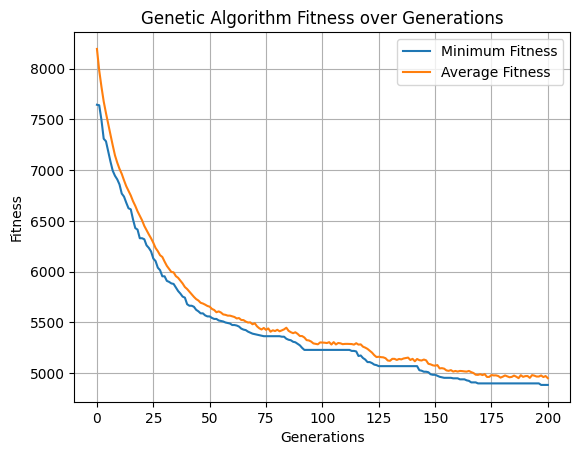

In [9]:
# Extract the fitness values from the logbook
min_fitness_values = [x['min'] for x in logbook]
avg_fitness_values = [x['avg'] for x in logbook]

# Plot the fitness values
plt.plot(min_fitness_values, label='Minimum Fitness')
plt.plot(avg_fitness_values, label='Average Fitness')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Genetic Algorithm Fitness over Generations')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print("Best individual is: %s, %s" % (hof[0], hof[0].fitness))

Best individual is: [[5, 6, 4, 4, 5, 4, 5], [7, 6, 6, 6, 3, 2, 3], [7, 4, 6, 2, 5, 4, 4], [4, 2, 7, 6, 3, 4, 4], [6, 7, 3, 2, 5, 4, 4], [7, 4, 4, 5, 5, 3, 1], [4, 2, 2, 4, 4, 5, 6], [6, 6, 2, 2, 3, 5, 5], [1, 1, 6, 2, 2, 5, 5], [4, 2, 4, 3, 2, 2, 1], [1, 4, 5, 6, 2, 7, 6], [2, 2, 5, 6, 5, 2, 4], [6, 2, 1, 3, 1, 3, 3], [3, 1, 2, 2, 1, 4, 3], [4, 2, 5, 4, 4, 5, 6], [1, 5, 4, 1, 6, 1, 1], [1, 3, 2, 5, 5, 4, 4], [3, 6, 6, 7, 2, 3, 5], [5, 4, 5, 6, 2, 4, 1], [5, 4, 3, 4, 1, 3, 1], [2, 5, 5, 1, 4, 2, 6], [4, 2, 4, 1, 6, 5, 2], [5, 3, 1, 4, 3, 6, 2], [4, 1, 4, 5, 6, 4, 2], [6, 2, 2, 5, 2, 6, 6], [6, 2, 2, 6, 4, 3, 3], [6, 4, 4, 2, 7, 7, 6], [5, 4, 3, 2, 2, 5, 5], [2, 5, 2, 4, 1, 1, 1], [3, 5, 6, 5, 4, 6, 6], [4, 6, 3, 4, 5, 6, 2], [5, 5, 4, 2, 5, 3, 3], [1, 1, 7, 2, 3, 3, 2], [3, 1, 3, 7, 7, 1, 1], [4, 5, 3, 3, 5, 1, 5], [4, 6, 2, 3, 1, 1, 6], [4, 6, 4, 2, 5, 6, 4], [1, 7, 2, 2, 3, 5, 1], [3, 4, 7, 2, 1, 2, 7], [7, 3, 2, 1, 3, 1, 5], [5, 3, 3, 3, 1, 3, 4], [4, 2, 1, 5, 1, 4, 4], [1, 2, 4, 1, 

In [11]:
# Create a list to store the data for the new dataframe
employee_data = []

# Iterate through each employee's schedule in the best individual
for employee_index, employee_schedule in enumerate(best_individual):
  employee_name = data.iloc[employee_index][0]  # Assuming the name is in the first column
  # Assuming 'SHIFTS' is a dictionary mapping shift IDs to their values
  schedule_details = []
  for day, shift_id in enumerate(employee_schedule):
    start_time, end_time = SHIFTS[shift_id]  # Get shift start and end times
    day_name = calendar.day_name[(datetime.now().weekday() + day) % 7]  # Calculate day name
    schedule_details.append({
        'Day': day_name,
        'Shift': (start_time, end_time)  # Store shift as a tuple or another suitable format
    })
  employee_data.append({
      'Employee': employee_name,
      'Schedule': schedule_details
  })

# Convert the list to a dataframe
result_df = pd.DataFrame(employee_data)
result_df

# Save the dataframe to a CSV file
result_df.to_csv('schedule_result_5.csv', index=False)

C:\Users\hendr\AppData\Local\Temp\ipykernel_31672\4052218462.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  employee_name = data.iloc[employee_index][0]  # Assuming the name is in the first column
